Let's give Conifer another chance. It could suffer from the same issues as XHMM, especially if we consider that the CCGO samples (removed in the 84 samples simplex analysis) might come form a separate batch. Conifer asks for at least 8 in each batch. But maybe this means that the results of the 84 samples (all CLIA) will be nice enough.

Also, Conifer says it works best with samples using multiple alignments per read. I don't know if the GATK pipeline does that, so that's something else to try in the future. Finally, we could use DNAcopy for segmentation (also suggested in the Conifer FAQ), instead of the simpler threshold crosisng method. However, note that this simple threshold method was used here: https://www.nature.com/articles/gim2016163 (genetics in medicine), so maybe it's not as bad.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [4]:
fid = open('/data/sudregp/cnv/conifer84/samples.txt', 'w')
for s in samples:
    fid.write(s + '\n')
fid.close()

fid = open('/data/sudregp/cnv/conifer84/kid_samples.txt', 'w')
for s in kids:
    fid.write(s + '\n')
fid.close()

In [ ]:
#  in terminal

cd ~/data/cnv/conifer84
mkdir RPKM
module load python
source activate my_py2.7

# copying from previous values, but will need to re-run it (costly!) if 
# trying to use mrsfast laster
probes=/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed

while read s; do
    cp ~/data/cnv/conifer/RPKM/${s}* RPKM/.;
done < samples.txt
ls -1 RPKM | wc -l

python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py analyze \
    --probes $probes \
    --rpkm_dir ./RPKM/ --output analysis.hdf5 --svd 6 \
    --write_svals singular_values.txt --plot_scree screeplot.png \
    --write_sd sd_values.txt
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py call \
    --input analysis.hdf5 --output calls.txt


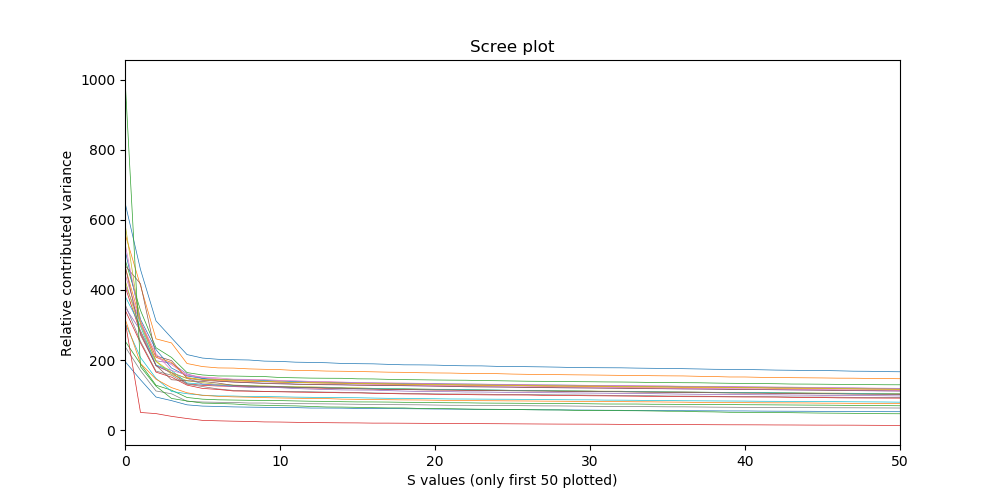

It's more like 5, so I need to re-run that. Or find a better threshold based on elbow, or DNAcopy. Also need to check the SD values for all samples as QC (see first note on other WES CNV tools).

Philip also wants me to do a deeper exploration of the XHMM results using only the CLIA samples, and also see how they change if we remove another family of four samples. He also thinks we should check both exome bead SNPs and whole genome SNPs for all results. The whole genome SNPs have the benefit of being a different sample, but they might not cover the exome as well as the exome bead SNPs. We need to check that, though.